## Build an MTH5 and Operate the Aurora Pipeline

This notebook pulls MT miniSEED data from the IRIS Dataselect web service to produce an MTH5 file, and then process the time series to create transfer function outputs. 

It outlines the process of making an MTH5 file, generating a processing configuration object, and running the Aurora processor.

Aurora must be installed to run the notebook. Installation instructions are [here](http://simpeg.xyz/aurora/). This will also install `mth5`, `mt_metadata` and `mtpy-v2`.

### Flow of this notebook

Section 1: Construct a table of the data that will be accessed(in future this process may be automated via Earthscope's data availability tools).  The table is then used to build an MTH5 archive.

Section 2: The metadata and the data are accessed and used to process the data and generate transfer functions.

In [1]:
# # Uncomment while developing
# %load_ext autoreload
# %autoreload 2


In [2]:
# Required imports for the program. 
from pathlib import Path
import pandas as pd
import warnings

from mth5 import mth5, timeseries
from mth5.clients.fdsn import FDSN
from mth5.clients.make_mth5 import MakeMTH5
from mth5.utils.helpers import initialize_mth5
from mt_metadata.common.mttime import get_now_utc, MTime
from aurora.config import BANDS_DEFAULT_FILE
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from mth5.processing import RunSummary, KernelDataset

warnings.filterwarnings('ignore')

## 1. Build an MTH5 file from Earthscope archives

- If you have already built an MTH5 you can skip this section 


Set path so MTH5 file builds to current working directory. 

In [3]:
default_path = Path().cwd()
default_path

WindowsPath('c:/Users/peaco/OneDrive/Documents/GitHub/aurora/docs/examples')

Select mth5 file version

In [4]:
# mth5_version = '0.1.0'
mth5_version = '0.2.0'


In [5]:
# Initalize an FDSN object to access column names for request df
fdsn_obj = FDSN()

### 1A: Specify the data to access from IRIS

Note that here we explicitly prescribe the data, but this dataframe could be built from IRIS data availability tools in a programatic way

In [6]:
# Generate data frame of FDSN Network, Station, Location, Channel, Startime, Endtime codes of interest
station_id = "CAS04"

CAS04LQE = ['8P', station_id, '', 'LQE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04LQN = ['8P', station_id, '', 'LQN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFE = ['8P', station_id, '', 'LFE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFN = ['8P', station_id, '', 'LFN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFZ = ['8P', station_id, '', 'LFZ', '2020-06-02T19:00:00', '2020-07-13T19:00:00']

request_list = [CAS04LQE, CAS04LQN, CAS04BFE, CAS04BFN, CAS04BFZ]

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=fdsn_obj.request_columns)

# Note that the file that will be build 
h5_basename = f"8P_{station_id}.h5"
print(f"The MTH5 file will be named (automatically) based on the network and station: {h5_basename}") 

The MTH5 file will be named (automatically) based on the network and station: 8P_CAS04.h5


In [7]:
# Inspect the dataframe
request_df

,network,station,location,channel,start,end
0,8P,CAS04,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
1,8P,CAS04,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00
2,8P,CAS04,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
3,8P,CAS04,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
4,8P,CAS04,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00


In [8]:
# Request the inventory information from IRIS
inventory = fdsn_obj.get_inventory_from_df(request_df, data=False)

In [9]:
# Inspect the inventory
inventory

(Inventory created at 2026-01-21T04:12:38.015965Z
	Created by: ObsPy 1.4.1
		    https://www.obspy.org
	Sending institution: MTH5
	Contains:
		Networks (1):
			8P
		Stations (1):
			8P.CAS04 (Corral Hollow, CA, USA)
		Channels (8):
			8P.CAS04..LFZ, 8P.CAS04..LFN, 8P.CAS04..LFE, 8P.CAS04..LQN (2x), 
			8P.CAS04..LQE (3x),
 0 Trace(s) in Stream:
)

Builds an MTH5 file from the user defined database. 

With the mth5 object set, we are ready to actually request the data from the fdsn client (IRIS) and save it to an MTH5 file.  This process builds an MTH5 file and can take some time depending on how much data is requested.  

Note: `interact` keeps the MTH5 open after it is done building


In [10]:
mth5_path = MakeMTH5.from_fdsn_client(request_df, mth5_filename=None)

2026-01-20T20:12:45.005080-0800 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | line: 138 | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2026-01-20T20:12:45.005080-0800 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | line: 138 | Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter.
2026-01-20T20:12:45.021679-0800 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | line: 138 | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2026-01-20T20:12:45.021679-0800 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | line: 138 | Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter.
2026-01-20T20:12:45.038358-0800 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | line: 138 | Converting PoleZerosResponseStage electric_si_units to a

### 1B: Examine and Update the MTH5 object

With the open MTH5 Object, we can start to examine what is in it. For example, retrieve the filename and file_version. You can additionally do things such as getting the station information and edit it by setting a new value, in this case the declination model. 

In [11]:
mth5_object = initialize_mth5(mth5_path)

In [12]:
mth5_object.file_version


'0.2.0'

### 1C: Optionally Update Metdata:

In [13]:
# Edit and update the MTH5 metadata 
s = mth5_object.get_station(station_id, survey="CONUS_South")
print(s.metadata.location.declination.model)
s.metadata.location.declination.model = 'IGRF'
print(s.metadata.location.declination.model)
s.write_metadata()    # writes to file mth5_filename

IGRF-13
IGRF


In [14]:
# Print some info about the mth5 
mth5_filename = mth5_object.filename
version = mth5_object.file_version
print(f" Filename: {mth5_filename} \n Version: {version}")


 Filename: c:\Users\peaco\OneDrive\Documents\GitHub\aurora\docs\examples\8P_CAS04.h5 
 Version: 0.2.0


In [15]:
# Get the available stations and runs from the MTH5 object
mth5_object.channel_summary.summarize()
ch_summary = mth5_object.channel_summary.to_dataframe()

## 2: Process Data
If MTH5 file already exists you can start here if you dont want to execute the previous code to get data again.

In [16]:
interact = False
if interact:
    pass
else:
    h5_basename = f"8P_{station_id}.h5"
    h5_path = default_path.joinpath(h5_basename)
    mth5_object = initialize_mth5(h5_path, mode="a", file_version=mth5_version)
    ch_summary = mth5_object.channel_summary.to_dataframe()



### Generate an Aurora Configuration file using MTH5 as an input

Up to this point, we have used mth5 and mt_metadata, but haven't yet used aurora. So we will use the MTH5 that we just created (and examined and updated) as input into Aurora.



### Channel Summary

This is a very useful datastructure inside the mth5.   It acts basically like an index of available data at the channel-run level, i.e. there is one row for every contiguous chunk of time-series recorded by an electric dipole or magnetometer

In [17]:
ch_summary

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,has_data,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,ex,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,ey,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,hx,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,hy,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,hz,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,0.0,90.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


The Channel summary has a lot of uses, below we use it to check if the data have mixed sample rates, and to get a list of available stations

In [18]:
available_runs = ch_summary.run.unique()
sr = ch_summary.sample_rate.unique()
if len(sr) != 1:
    print('Only one sample rate per run is available')
    
available_stations = ch_summary.station.unique()
print(f"Available stations: {available_stations}")

Available stations: ['CAS04']


### Run Summary

A cousin of the channel summary is the Run Summary.
This is a condensed version of the channel summary, with one row per continuous acquistion run at a station.

The run summary can be accessed from an open mth5 object, or from an iterable of h5 paths as in the example below


In [19]:
mth5_run_summary = RunSummary()
h5_path = default_path.joinpath(h5_basename)
mth5_run_summary.from_mth5s([h5_path,])
run_summary = mth5_run_summary.clone()
run_summary.df

2026-01-20T20:13:15.146646-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing c:\Users\peaco\OneDrive\Documents\GitHub\aurora\docs\examples\8P_CAS04.h5


,channel_scale_factors,duration,end,has_data,input_channels,mth5_path,n_samples,output_channels,run,sample_rate,start,station,survey,run_hdf5_reference,station_hdf5_reference
0,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",11266.0,2020-06-02 22:07:46+00:00,True,"[hx, hy]",c:/Users/peaco/OneDrive/Documents/GitHub/auror...,11267,"[ex, ey, hz]",a,1.0,2020-06-02 19:00:00+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
1,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",847648.0,2020-06-12 17:52:23+00:00,True,"[hx, hy]",c:/Users/peaco/OneDrive/Documents/GitHub/auror...,847649,"[ex, ey, hz]",b,1.0,2020-06-02 22:24:55+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
2,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1638042.0,2020-07-01 17:32:59+00:00,True,"[hx, hy]",c:/Users/peaco/OneDrive/Documents/GitHub/auror...,1638043,"[ex, ey, hz]",c,1.0,2020-06-12 18:32:17+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
3,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1034585.0,2020-07-13 19:00:00+00:00,True,"[hx, hy]",c:/Users/peaco/OneDrive/Documents/GitHub/auror...,1034586,"[ex, ey, hz]",d,1.0,2020-07-01 19:36:55+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>


Now we have a dataframe of the available runs to process from the MTH5 

Sometimes we just want to look at the survey, station, run, and time intervals
we can for that we can call mini_summary

In [20]:
run_summary.mini_summary

,survey,station,run,start,end,duration
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11266.0
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847648.0
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00,1638042.0
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00,1034585.0


But here are the columns in the run summary

In [21]:
run_summary.df.columns

Index(['channel_scale_factors', 'duration', 'end', 'has_data',
       'input_channels', 'mth5_path', 'n_samples', 'output_channels', 'run',
       'sample_rate', 'start', 'station', 'survey', 'run_hdf5_reference',
       'station_hdf5_reference'],
      dtype='object')

 Make your own mini summary by choosing columns

In [22]:
coverage_short_list_columns = ["survey", 'station', 'run', 'start', 'end', ]
run_summary.df[coverage_short_list_columns]

,survey,station,run,start,end
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00


### Kernel Dataset

This is like a run summary, but for a single station or a pair of stations.
It is used to specify the inputs to aurora processing.

It takes a run_summary and a station name, and optionally, a remote reference station name

It is made _based on the available data_ in the MTH5 archive.

Syntax:
kernel_dataset.from_run_summary(run_summary, local_station_id, reference_station_id)

By Default, all runs will be processed

To restrict to processing a single run, or a list of runs, we can either tell KernelDataset to keep or drop a station_run dictionary. 


In [23]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station_id)
kernel_dataset.mini_summary

2026-01-20T20:13:16.595425-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing c:\Users\peaco\OneDrive\Documents\GitHub\aurora\docs\examples\8P_CAS04.h5


,survey,station,run,start,end,duration
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11266.0
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847648.0
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00,1638042.0
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00,1034585.0


## Here is one way to select a single run:


In [24]:
station_runs_dict = {}
station_runs_dict[station_id] = ["a", ]
keep_or_drop = "keep"

kernel_dataset.select_station_runs(station_runs_dict, keep_or_drop)
print(kernel_dataset.df[coverage_short_list_columns])

        survey station run                     start                       end
0  CONUS South   CAS04   a 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00


## To discard runs that are not very long

In [25]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station_id)
cutoff_duration_in_seconds = 15000
kernel_dataset.drop_runs_shorter_than(cutoff_duration_in_seconds)
kernel_dataset.df[coverage_short_list_columns]

2026-01-20T20:13:18.448795-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing c:\Users\peaco\OneDrive\Documents\GitHub\aurora\docs\examples\8P_CAS04.h5


,survey,station,run,start,end
0,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
1,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
2,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00


### Select only runs "b" & "d"

In [26]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04")
station_runs_dict = {}
station_runs_dict[station_id] = ["b","d"]
keep_or_drop = "keep"
kernel_dataset.select_station_runs(station_runs_dict, keep_or_drop)
kernel_dataset.df[coverage_short_list_columns]

2026-01-20T20:13:21.320009-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing c:\Users\peaco\OneDrive\Documents\GitHub\aurora\docs\examples\8P_CAS04.h5


,survey,station,run,start,end
0,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
1,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00


### The same result can be obtained by _excluding_ runs a & c

In [27]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station_id)
station_runs_dict = {}
station_runs_dict[station_id] = ["a","c"]
keep_or_drop = "drop"
kernel_dataset.select_station_runs(station_runs_dict, keep_or_drop)
kernel_dataset.df[coverage_short_list_columns]

2026-01-20T20:13:23.205829-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing c:\Users\peaco\OneDrive\Documents\GitHub\aurora\docs\examples\8P_CAS04.h5


,survey,station,run,start,end
0,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
1,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00


## To process only a segment of data

Say that you have weeks of data available, but you want to restrict the data processed to a subset.  If it is one contiguous subset block, you can just modify the run_summary table as below.  You should also update the duration column by calling kernel_dataset._add_duration_column() afterwards:

In [28]:
# kernel_dataset.df["start"].iloc[0] += pd.Timedelta(days=5)
# kernel_dataset.df["start"].iloc[1] += pd.Timedelta(days=7)
# kernel_dataset._add_duration_column()


## Exercise: 
- Print the kernel_dataset dataframe by calling `kernel_dataset.df`
- Modify the start and end times, call _add_duration_column() and print it again.
- You can also process the data with and without this change
- Are the TFs different?

Make an aurora configuration file (and then save that json file.)

In [29]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset, 
                                       emtf_band_file=BANDS_DEFAULT_FILE,)


In [30]:
for decimation in config.decimations:
    # decimation.output_channels = ["ex", "ey"]
    decimation.estimator.engine = "RME"

Take a look at the config:

In [31]:
config

{
    "processing": {
        "band_setup_file": "C:\\Users\\peaco\\OneDrive\\Documents\\GitHub\\aurora\\aurora\\config\\emtf_band_setup\\bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "channel_nomenclature.keyword": "default",
        "decimations": [
            {
                "decimation_level": {
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.119140625,
                                "frequency_min": 0.095703125,
                                "index_max": 30,
                            

### What if I have unconventional channel names? 

Aurora uses "ex", "ey", "hx", "hy", "hz" as default names, but not all MTH5 files will use this nomenclauture.
For example, files generated from some Phoenix system call channels "e1", "e2", "h1", "h2", "h3"

A complete list of supported channel mappings is in mt_metadata/transfer_functions/processing/aurora/standards/channel_nomenclatures.json

Here is an exmaple of how update the config in this case:

In [32]:
# config.channel_nomenclature.keyword = "phoenix123"
# config.set_default_input_output_channels()
# config.set_default_reference_channels()

## Exercise:

- Print the processing config by calling config
- Modify the nomenclature using the above code, and print it again.
- Confirm that the two configs are different.  Can you spot the differences?


Run the Aurora Pipeline using the input MTh5 and Confiugration File

2026-01-20T20:13:23.917192-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 290 | Processing Summary Dataframe:
2026-01-20T20:13:23.921194-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | line: 291 | 
    duration  has_data  n_samples run station       survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   847648.0      True     847649   b   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            256.0                 256     847648.0            3784.0
1   847648.0      True     847649   b   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000           1024.0                 256     211912.0             945.0


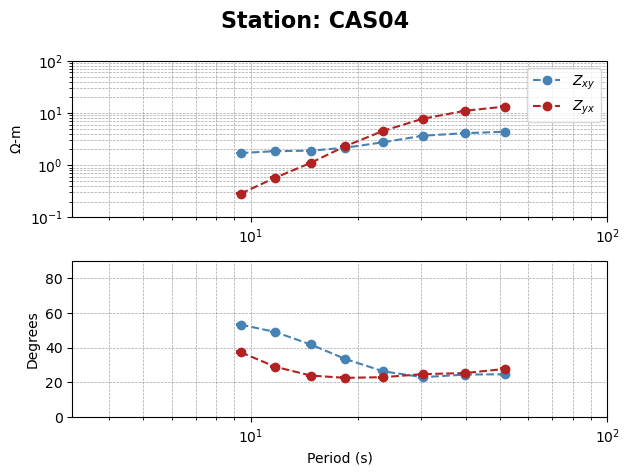

2026-01-20T20:13:45.284425-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 1
2026-01-20T20:13:45.504477-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 1 Successfully
2026-01-20T20:13:47.382484-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-20T20:13:49.029179-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-20T20:13:49.038840-0800 | INFO | aurora.pipelines.feature_weights | extract_features | line: 43 | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)
2026-01-20T20:13:49.059227-0800 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | line: 46 | Accessing band

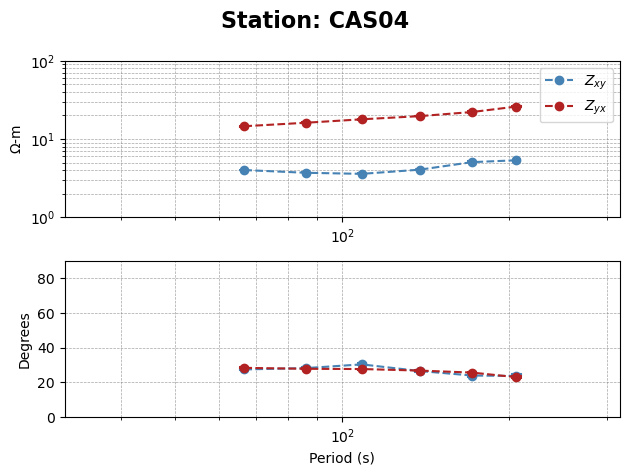

2026-01-20T20:13:51.306035-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 2
2026-01-20T20:13:51.378528-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 2 Successfully
2026-01-20T20:13:52.940594-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-20T20:13:55.390737-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-20T20:13:55.390737-0800 | INFO | aurora.pipelines.feature_weights | extract_features | line: 43 | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)
2026-01-20T20:13:55.424611-0800 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | line: 46 | Accessing band

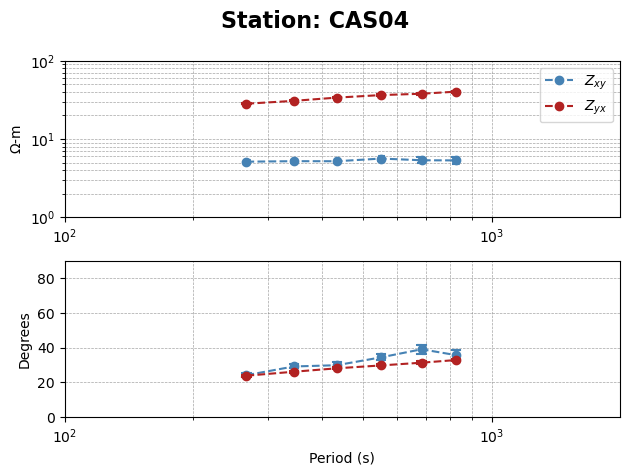

2026-01-20T20:13:57.507633-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 137 | DECIMATION LEVEL 3
2026-01-20T20:13:57.545901-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | line: 156 | Dataset Dataframe Updated for decimation level 3 Successfully
2026-01-20T20:13:59.041684-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-20T20:14:00.864792-0800 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | line: 341 | Skip saving FCs. dec_level_config.save_fc =  False
2026-01-20T20:14:00.877486-0800 | INFO | aurora.pipelines.feature_weights | extract_features | line: 43 | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)
2026-01-20T20:14:00.894180-0800 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | line: 46 | Accessing band

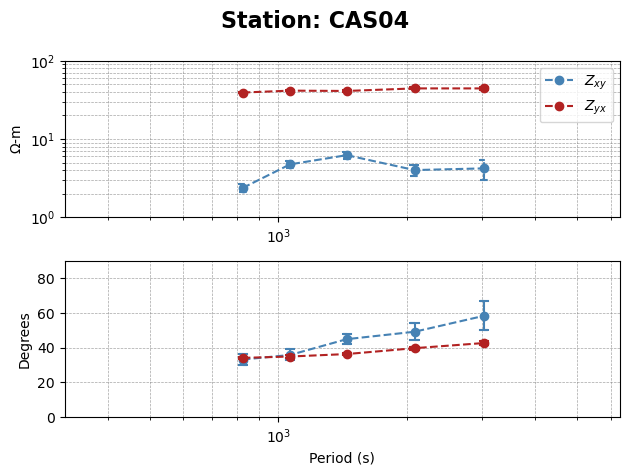

2026-01-20T20:14:02.809024-0800 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | line: 230 | type(tf_cls): <class 'mt_metadata.transfer_functions.core.TF'>
2026-01-20T20:14:02.977049-0800 | INFO | mth5.mth5 | close_mth5 | line: 896 | Flushing and closing c:\Users\peaco\OneDrive\Documents\GitHub\aurora\docs\examples\8P_CAS04.h5


In [33]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

In [34]:

type(tf_cls)

mt_metadata.transfer_functions.core.TF

Write the transfer functions generated by the Aurora pipeline

In [35]:
tf_cls.write(fn="emtfxml_test.xml", file_type="emtfxml")

EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=335.26)

In [36]:
tf_cls.write(fn="emtfxml_test.edi", file_type="edi")

Station: CAS04
--------------------------------------------------
	Survey:        CONUS South
	Project:       USMTArray
	Acquired by:   
	Acquired date: 2020-06-02T18:41:43+00:00
	Latitude:      37.633
	Longitude:     -121.468
	Elevation:     335.262
	Impedance:     True
	Tipper:        True
	Number of periods: 25
		Period Range:   9.36498E+00 -- 3.02940E+03 s
		Frequency Range 3.30098E-04 -- 1.06781E-01 s

In [37]:
tf_cls.write(fn="emtfxml_test.zss", file_type="zmm")

MT( station='CAS04', latitude=37.63, longitude=-121.47, elevation=335.26 )